In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# To display all columns:
pd.pandas.set_option('display.max_columns', None)

## Loding Data:

In [2]:
df1 = pd.read_csv('../data/interim/train_MICE_median_ind_QuantileTransformer.csv')
df2 = pd.read_csv('../data/interim/train_MICE_med_ind_QT_dropOutlier.csv')

In [3]:
X, y = df1.drop(columns=['Weight', 'Label']), df1['Weight']
X2, y2 = df2.drop(columns=['Weight', 'Label']), df2['Weight']

In [4]:
print(df1.shape, df2.shape, sep='\n')

(250000, 33)
(236794, 33)


## Visualizing Weight column:

<AxesSubplot:xlabel='Weight', ylabel='Count'>

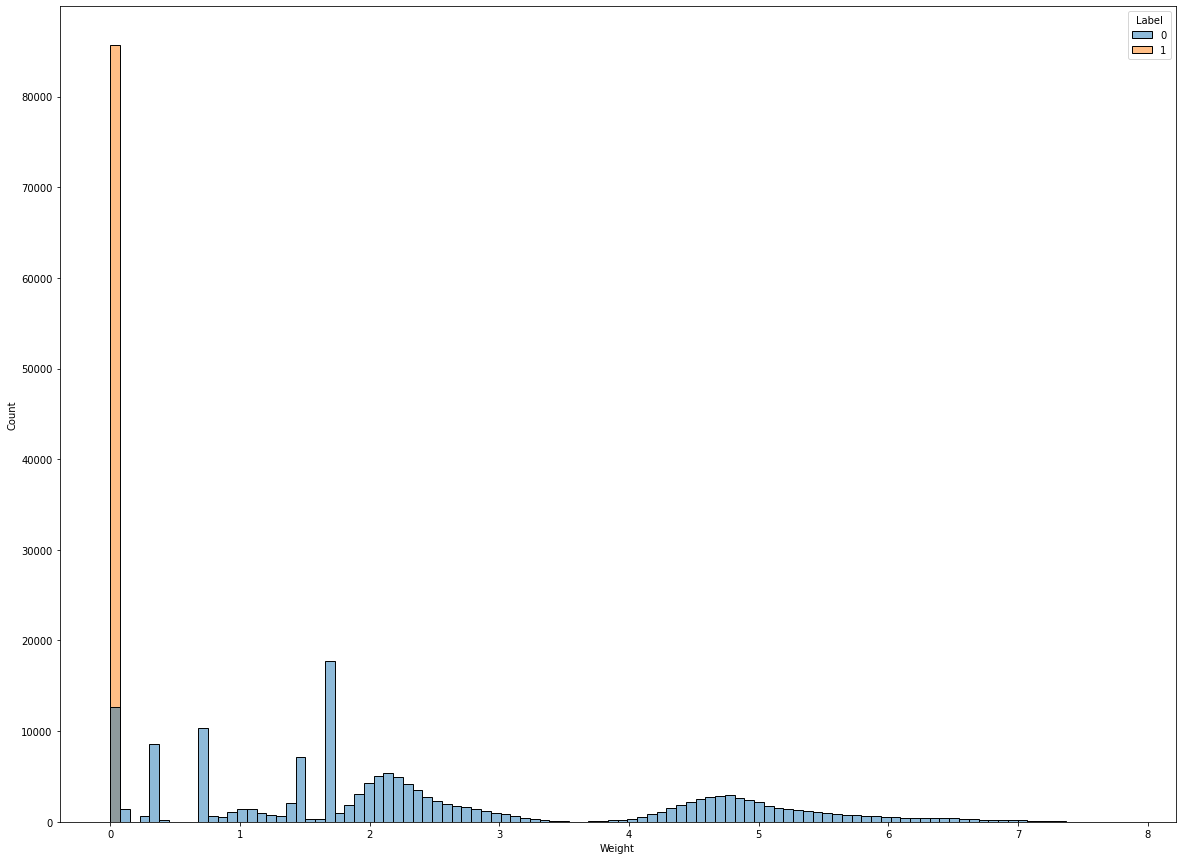

In [15]:
plt.figure(figsize=(20, 15))
sns.histplot(data=df1, x='Weight', hue='Label')

<AxesSubplot:xlabel='Weight', ylabel='Count'>

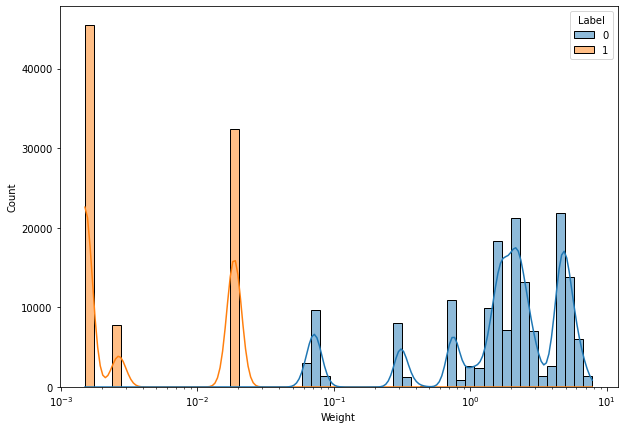

In [11]:
plt.figure(figsize=(10, 7))
sns.histplot(data=df1, x='Weight', hue='Label', log_scale=True, kde=True)

## Train-test split:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30000)     # about 12%
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=30000)   # about 12%

## Grid Search CV:

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [32]:
scores = []
model_info = pd.DataFrame([])

def find_best_model_using_gridsearchcv (X, y, keep=True):
    algos = {
        'Linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'SVR': {
            'model': SVR(max_iter=1000),
            'params': {
                'kernel': ['rbf', 'linear', 'poly'],
                'C': np.arange(5, 51, 5),
                 
            }
        },
        'Decision tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse', 'friedman_mse', 'poisson'],
                'splitter': ['best', 'random'],
                'max_depth': np.arange(6, 13),
                'min_samples_split': [150, 200, 250, 300],
                'min_samples_leaf': [50, 100],
                'max_features': ['auto', 0.9, 'sqrt', 'log2']
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(criterion='mse'),
            'params': {
                'n_estimators': [80, 90, 100],
                'splitter': ['best', 'random'],
                'max_depth': np.arange(6, 10),
                'min_samples_split': [150, 200, 250, 300],
                'min_samples_leaf': [50, 100],
                'max_features': ['auto', 0.9, 'sqrt', 'log2'],
                'max_samples': [0.8, 0.9, 0.95]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(verbosity=0, booster='gbtree'),
            'params': {
                'n_estimator': [50, 75, 100],
                'max_depth': [8, 9, 10, 11]
            }
        },
        'XGBoost RF': {
            'model': xgb.XGBRFRegressor(verbosity=0, booster='gbtree'),
            'params': {
                'n_estimator': [50, 75, 100],
                'max_depth': [8, 9, 10, 11]
            }
        }
    }
    
    
    if keep:
        global scores, model_info
    else:
        scores = []
        model_info = pd.DataFrame([])

        
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=5, scoring='neg_mean_squared_error', 
                           n_jobs = -1, return_train_score=False)
        gs.fit(X,y)

        
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        model_info = model_info.append(pd.DataFrame(gs.cv_results_), ignore_index=True)
        
        
        ## Printing values:
        print(algo_name, '-- best score --', gs.best_score_, '\nParams:', gs.best_params_)
        print('\n\n', pd.DataFrame(gs.cv_results_), '\n\n\n')
        
    return (pd.DataFrame(scores, columns=['model', 'best_score', 'best_params']), model_info)

In [ ]:
find_best_model_using_gridsearchcv(X_train, y_train)

Linear_regression -- best score -- -1.796701995408256 
Params: {'normalize': True}


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.684516      0.122590         0.235052        0.036589   
1       1.376319      0.323232         0.179523        0.047402   

  param_normalize                params  split0_test_score  split1_test_score  \
0            True   {'normalize': True}          -1.792171          -1.793134   
1           False  {'normalize': False}          -1.792171          -1.793134   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0          -1.787447          -1.814331          -1.796427        -1.796702   
1          -1.787447          -1.814331          -1.796427        -1.796702   

   std_test_score  rank_test_score  
0        0.009271                1  
1        0.009271                2   



Lasso -- best score -- -2.6751379147149037 
Params: {'alpha': 1, 'selection': 'cyclic'}


    mean_fit_time  std_fi

In [30]:
pd.DataFrame([]).append(df1, ignore_index=True)

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,ind_15,ind_40,ind_70,Weight,Label
0,0.105712,0.846853,-0.281832,-1.440634,-1.392330,1.819752,0.893908,1.227406,0.437620,1.236652,...,0.395113,0.850104,1.298783,-1.864348,0.705481,False,False,False,0.002653,1
1,0.523305,0.993621,0.206519,0.437861,0.180620,-0.579631,1.675206,-0.892661,-0.680013,5.199338,...,0.865277,0.557937,0.447191,0.752929,0.096192,False,False,True,2.233584,0
2,2.486980,1.404950,-0.065154,-0.671441,-0.682643,0.564616,1.137677,-0.069578,2.069243,5.199338,...,-1.246608,0.567757,-1.198176,1.155143,0.067556,True,False,True,2.347389,0
3,0.933682,0.289815,-2.269115,0.445044,0.435037,-0.327320,1.457621,-2.031581,1.245323,-0.374936,...,0.692627,0.317645,-0.443773,0.919892,-5.199338,False,True,True,5.446378,0
4,-0.758808,1.501841,-0.637574,1.043956,0.860625,-0.915816,2.094339,0.079973,-0.373591,-0.791884,...,0.207315,-0.592731,-0.253991,0.287972,-5.199338,False,True,True,6.245333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.619605,-1.690756,-0.907023,-0.312863,-0.163394,0.370532,-1.108218,-0.316425,-0.040157,-5.199338,...,-0.487510,0.178886,-0.375024,-0.333285,-5.199338,True,True,True,4.505083,0
249996,0.252122,-0.250798,-0.484559,0.343613,0.231292,-0.156300,0.103057,0.319515,-0.194422,-0.535083,...,-0.543825,-0.735224,-0.217709,-0.636376,-5.199338,True,True,True,2.497259,0
249997,0.306240,0.090217,0.032823,-0.350595,-0.477485,0.302523,-0.111890,0.303270,-0.129582,0.241705,...,-0.132113,-0.382384,-0.809472,1.100288,0.031202,False,False,True,0.018636,1
249998,-0.675038,-0.217736,-0.680013,1.513251,1.407011,-1.478315,1.537691,0.024581,-0.466803,5.199338,...,-0.545752,-0.454991,-0.711483,-0.722445,-5.199338,False,True,True,1.681611,0


In [3]:
# For changing styling:
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("styles/custom.css", "r").read()
#     return HTML(styles)
# css_styling()